In [136]:
from Ge_calculation import GAP, MD_run, flatten
from ase.io.extxyz import read_xyz
import numpy as np
import json
import os
from snap import *
from quippy.potential import Potential

import pymatgen.ext.matproj as mp
import pymatgen.core.periodic_table as pt
import pymatgen.io.ase as pase
import matplotlib.pyplot as plt

In [3]:
file = '/home/joe/mlip_test/gp_iter6_liqamo_lp.xyz'
with open(file) as f:
    db = list(read_xyz(f, index=slice(0,None)))
db_min = db[0:4]

In [104]:
with open('/home/joe/Documents/Ge_od/Potentials/Si_myDB_supercrystals/Si_myDB_liqamocryst_train.xyz') as f:

    liqamocryst = list(read_xyz(f, index=slice(0,None)))

In [4]:
def write_json_db(a, d="", force_name='dft_force', virial_name='dft_virial', energy_name='dft_energy',
                  weights_dict={}, weights_default=[100, 1, 1e-8]):
    """Writes a list of atoms to the MTP mlip-2 cfg database file format
    WARNING: incurs loss of array information other than positions and forces of atoms.
    Atoms.info dict is stored as features
    Params: set the key words for the forces, energy, and virials if they differ from the defaults above
    """
    d = os.path.join(d, "JSON")
    if not os.path.isdir(d):
        os.makedirs(d)

   # divide DB into list of lists based on config_type
    configs = []; types_list = []
    for i in a:
        if 'config_type' not in i.info.keys():
            i.info['config_type'] = 'default'
        if i.info['config_type'] not in types_list:
            types_list.append(i.info['config_type'])
            configs.append([])
            configs[-1].append(i)
        else:
            configs[types_list.index(i.info['config_type'])].append(i)

    type_lengths = [len(i) for i in configs]
    for i in types_list:
        if i not in weights_dict.keys():
            weights_dict.update({i: weights_default})

    for ci, i in enumerate(configs):
        path = os.path.join(d, types_list[ci])
        os.mkdir(path)
        no_stress_indices = []

        for ct, val in enumerate(i):
            Lattice = val.get_cell()
            det = np.linalg.det(Lattice)
            if det < 0:
                print('Warning, left-handed axes detected, skipping this config:')
                print(det, types_list[ci], 'No.', ct)
                type_lengths[ci] -= 1
                continue
            NumAtoms = len(val)
            AtomTypes = val.get_chemical_symbols()
            Positions = val.get_positions(wrap=True)

            if virial_name in val.info.keys() and 'no_stress' not in val.info['config_type']:
                if isinstance(val.info[virial_name], np.ndarray):
                    Stress = -1e4*np.reshape(val.info[virial_name], (3,3))/val.get_volume()
                    # Need to check that this is the correct form for the stress:
                    # currently as Castep outputs (i.e. non-virial (mechanical) stress, converted to Bar
            elif 'no_stress' not in val.info['config_type']:
                if (td := types_list[ci] + '_no_stress') not in types_list: # move to the relevant *no_stress folder
                    configs.append([])
                    type_lengths.append(0)
                    types_list.append(td)
                    weights_dict.update({td: weights_dict[val.info['config_type']][:-1] + [0]}) # set stress weight to 0
                val.info['config_type'] = td
                configs[(ti := types_list.index(td))].append(val)
                type_lengths[ci] -= 1
                type_lengths[ti] += 1
                continue
            else:
                Stress = np.zeros((3,3))

            Forces = val.get_array(force_name)
            Energy = val.info[energy_name]

            data = {"Dataset": {"Data": [{
                    "Stress": Stress.tolist(),
                    "Positions": Positions.tolist(),
                    "Energy": Energy.tolist(),
                    "AtomTypes": AtomTypes,
                    "Lattice": Lattice.tolist(),
                    "NumAtoms": NumAtoms,
                    "Forces": Forces.tolist(),
                    }],
                    "PositionsStyle": "angstrom", "AtomTypeStyle": "chemicalsymbol",
                    "Label": types_list[ci], "StressStyle": "bar",
                    "LatticeStyle": "angstrom", "EnergyStyle": "electronvolt",
                    "ForcesStyle": "electronvoltperangstrom"
                    }}

            with open(os.path.join(d, types_list[ci], val.info['config_type'] + '_{}.json'.format(str(ct))), 'w') as f:
                f.write('# Comment line\n')
                json.dump(data, f)

    with open(os.path.join(d[:-4] + 'grouplist'), 'w') as f:
        f.write('# name size eweight fweight vweight\n')
        for i, val in enumerate(types_list):
            if type_lengths[i] > 0:
                f.write('{:40s}     {:<6d}     {:<7.10f}     {:<7.10f}    {:<7.10f}\n'.format(val, type_lengths[i], *weights_dict[val]))

In [10]:
os.chdir('/home/joe/Documents/Ge_od/Potentials/Si_myDB_supercrystals/SNAP')
write_json_db(liqamocryst)

In [9]:
os.chdir('/home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper')

In [5]:
file = '/home/joe/Documents/Ge_od/Structure_databases/gp_iter6_sparse9k.xml.xyz'
litDB_full = list(read_xyz(file, index=slice(0,None)))


In [22]:
write_json_db(litDB_full, weights_dict={'amorph':[2918, 21, 1e-8], 'liq':[2918, 21, 1e-8],
                                        'vacancy':[9308, 26, 1e-8], 'interstitial':[9308, 26, 1e-8]},
              weights_default=[2959, 62, 1e-5])

Warning, left-handed axes detected, skipping this config:
-328.14806848881676 decohesion No. 11
Warning, left-handed axes detected, skipping this config:
-325.2042066684052 decohesion No. 12
Warning, left-handed axes detected, skipping this config:
-336.2834397744042 decohesion No. 13
Warning, left-handed axes detected, skipping this config:
-354.1002531456985 decohesion No. 14
Warning, left-handed axes detected, skipping this config:
-358.28414584870234 decohesion No. 15
Warning, left-handed axes detected, skipping this config:
-353.528383869545 decohesion No. 16
Warning, left-handed axes detected, skipping this config:
-373.9481675578679 decohesion No. 17
Warning, left-handed axes detected, skipping this config:
-381.1629262665485 decohesion No. 18
Warning, left-handed axes detected, skipping this config:
-393.1966652384923 decohesion No. 19
Warning, left-handed axes detected, skipping this config:
-403.13971540917254 decohesion No. 20
Warning, left-handed axes detected, skipping thi

In [227]:
write_json_db(litDB_full, d='sw0_001', weights_default=[100, 1, 1e-3])



Warning, left-handed axes detected, skipping this config:
-328.14806848881676 decohesion No. 11
Warning, left-handed axes detected, skipping this config:
-325.2042066684052 decohesion No. 12
Warning, left-handed axes detected, skipping this config:
-336.2834397744042 decohesion No. 13
Warning, left-handed axes detected, skipping this config:
-354.1002531456985 decohesion No. 14
Warning, left-handed axes detected, skipping this config:
-358.28414584870234 decohesion No. 15
Warning, left-handed axes detected, skipping this config:
-353.528383869545 decohesion No. 16
Warning, left-handed axes detected, skipping this config:
-373.9481675578679 decohesion No. 17
Warning, left-handed axes detected, skipping this config:
-381.1629262665485 decohesion No. 18
Warning, left-handed axes detected, skipping this config:
-393.1966652384923 decohesion No. 19
Warning, left-handed axes detected, skipping this config:
-403.13971540917254 decohesion No. 20
Warning, left-handed axes detected, skipping thi

In [229]:
write_json_db(litDB_full, d='sw0_1', weights_default=[100, 1, 1e-1])

Warning, left-handed axes detected, skipping this config:
-328.14806848881676 decohesion No. 11
Warning, left-handed axes detected, skipping this config:
-325.2042066684052 decohesion No. 12
Warning, left-handed axes detected, skipping this config:
-336.2834397744042 decohesion No. 13
Warning, left-handed axes detected, skipping this config:
-354.1002531456985 decohesion No. 14
Warning, left-handed axes detected, skipping this config:
-358.28414584870234 decohesion No. 15
Warning, left-handed axes detected, skipping this config:
-353.528383869545 decohesion No. 16
Warning, left-handed axes detected, skipping this config:
-373.9481675578679 decohesion No. 17
Warning, left-handed axes detected, skipping this config:
-381.1629262665485 decohesion No. 18
Warning, left-handed axes detected, skipping this config:
-393.1966652384923 decohesion No. 19
Warning, left-handed axes detected, skipping this config:
-403.13971540917254 decohesion No. 20
Warning, left-handed axes detected, skipping thi

# Get a "calculator" working based on the lammps implementation of SNAP potentials




In [36]:
from ase.calculators.lammpslib import LAMMPSlib
from ase.data import atomic_numbers, atomic_names, atomic_masses
import os

class SNAP(LAMMPSlib):
    r"""
    Wrapper to the LAMMPSlib interface for SNAPs

    joe.morrow@queens.ox.ac.uk

    Getting Started:
    ================

    Running the Calculator:
    =======================


    TODO: A faster implementation for lists of atoms would be to write a single cfg for all of them
    """

    def __init__(self, atom_types, potential_seed='pot', potential_name=None,
                 zblcutinner=4.0,
                 zblcutouter=4.8,
                 ):
        '''atom_types - dict: mapping of atom symbols to snapparam lammps types e.g. {'Si:1, Ge:2, O:3, O:4}
           potential_seed -  path-like str: basename of the SNAP potential
           potential name - str: optional name for the potential for use in e.g. plot legends
           zblcutinner - float: parameter for the nuclear-repulsion zbl potential overlayed on the SNAP
           zblcutouter - float: ...
        '''

        if not os.path.isfile(potential_seed+'.snapcoeff') or not os.path.isfile(potential_seed+'.snapparam'):
            raise FileNotFoundError('SNAP potential \'{}\' does not exist'.format(potential_seed))

        self.potential_seed = potential_seed
        self.name = potential_name
        zblz = [atomic_numbers[i] for i in atom_types.keys()]

        lmpcmds = [
        "pair_style hybrid/overlay zbl {} {} snap".format(zblcutinner, zblcutouter),
        "pair_coeff * * zbl 0.0 0.0"] +\
        ["pair_coeff {0} {1} zbl {2} {3}".format(atom_types[i], atom_types[j],
                                                 atomic_numbers[i], atomic_numbers[j])
         for i in atom_types.keys() for j in atom_types.keys() if atom_types[i] >= atom_types[j]] +\
        [("pair_coeff * * snap {0}.snapcoeff {0}.snapparam " +\
          " ".join(["{{{}}}".format(i+1) for i in range(len(atom_types.keys()))])).format(
            potential_seed, *atom_types.keys())
        ]
        print(lmpcmds)

        LAMMPSlib.__init__(self, lmpcmds=lmpcmds, atom_types=atom_types)


In [31]:
zblcutinner = 4.0
zblcutouter = 4.8
zblz = 14.0
potential_seed = "/home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/Si_pot"
lmpcmds = [
"pair_style hybrid/overlay zbl {} {} snap".format(zblcutinner, zblcutouter),
"pair_coeff * * zbl 0.0 0.0",
"pair_coeff 1 1 zbl {0} {0}".format(zblz),
"pair_coeff * * snap {0}.snapcoeff {0}.snapparam Si".format(potential_seed)
]

atom_types = {'Si':1}

In [18]:
lmp = LAMMPSlib(lmpcmds=lmpcmds, atom_types=atom_types)

In [12]:
from ase.io.castep import read_castep_castep
from Ge_analysis import *
DFT_struct = []
DFT_struct_labels = ['', '', '', '', '', '', '', '', '', 'diamond']
DFT_dir = '/home/joe/Documents/Ge_od/Structure_databases/crystals/Si_MP_dense_cryst'
for i in os.listdir(DFT_dir):
    if '.castep' in i:
        DFT_struct.append(read_castep_castep(os.path.join(DFT_dir, i))[0])
        DFT_struct[-1].info['energy'] = get_castep_E(os.path.join(DFT_dir, i))

In [19]:
DFT_struct[5].set_calculator(lmp)

In [20]:
DFT_struct[5].get_stress()

array([-2.22558998e+00, -2.22557485e+00, -1.67611309e+00,  1.75323724e-14,
       -9.01620318e-15,  1.59853605e-15])

In [64]:
DFT_struct[6].set_calculator(SNAP(atom_types={'Si':1}, potential_seed=potential_seed, potential_name='test'))


['pair_style hybrid/overlay zbl 4.0 4.8 snap', 'pair_coeff * * zbl 0.0 0.0', 'pair_coeff 1 1 zbl 14 14', 'pair_coeff * * snap /home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/Si_pot.snapcoeff /home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/Si_pot.snapparam Si']


In [65]:
DFT_struct[6].get_stress()

array([ 6.31422271e+00,  6.31422271e+00,  6.31422271e+00,  1.24812442e-14,
       -1.13514750e-14,  1.36226124e-14])

# Validation of SNAPs on a test set

In [49]:
supers = '/home/joe/Documents/Ge_od/Potentials/Si_myDB_supercrystals/'
cost_based = '/home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper'

In [97]:
pots = [
        SNAP({'Si':1}, potential_seed=cost_based+"/t1/Si_pot",
                     potential_name='snap_test'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t2/Si_pot',
             potential_name='snap_shift'),
        SNAP({'Si':1}, potential_seed=os.path.join(supers, 'SNAP/Si_pot'), potential_name='SNAP_myDB'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t4/Si_pot',
             potential_name='snap_shift'),
        SNAP({'Si':1}, potential_seed='/home/joe/Documents/Ge_od/Potentials/SNAP_pots/myDB/t2/Si_pot',
             potential_name='snap_shift_my'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t5/Si_pot',
             potential_name='snap_shift_zbl_mod'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t6/Si_pot',
             potential_name='snap_shift_znl_none'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t7/Si_pot',
             potential_name='snap_shift_zbl_none_j6'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t8_j10/Si_pot',
             potential_name='snap_shift_j10'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t9_j12/Si_pot',
             potential_name='snap_shift_znl_j12'),
        SNAP({'Si':1}, potential_seed=cost_based+'/t10_j14/Si_pot',
             potential_name='snap_shift_zbl_none_j14')
        ]


In [137]:
GAP_example = Potential(param_filename='/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_ds0.075_0.75_0.375_0.0.xml'),

/home/joe/ase/ase/calculators/calculator.py:507: FutureWarning: The keyword "ignore_bad_restart_file" is deprecated and will be removed in a future version of ASE.  Passing more than one positional argument to Calculator is also deprecated and will stop functioning in the future.  Please pass arguments by keyword (key=value) except optionally the "restart" keyword.
  warnings.warn(FutureWarning(


In [13]:
pot_DBs = [GAP(train_file=file, pot=i, parameter_names=['dft_energy', 'dft_force', 'dft_virial']) for i in pots]

training set structure count: 214
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['liq', 'amorph']
training set structure count: 214
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['liq', 'amorph']
training set structure count: 214
reading xyz file (may take a while)
read configs, now fixing virials
config labels: ['liq', 'amorph']


In [17]:
pot_DBs[0].data_dict.keys()

dict_keys(['QM_E_t', 'QM_F_t', 'QM_V_t', 'QM_E_v', 'QM_F_v', 'QM_V_v', 'T_configs', 'V_configs'])

In [4]:
Ta_pot = SNAP({'Ta':1}, potential_seed='/home/joe/Program_python_path/FitSNAP/examples/Ta_Linear_JCP2014_test/Ta_pot',
              potential_name='Ta')


In [41]:
with mp.MPRester("v0JVgKLlpTXKEhiKeDIC") as m:
    results = m.query(criteria={"pretty_formula":'Ta'},
                            properties=["exp.tags", "icsd_ids", "spacegroup",
                                        "task_id", "density", "final_structure",
                                        "e_above_hull", "energy", "energy_per_atom"])
    #results = [m.get_structure_by_material_id(i, conventional_unit_cell=True) for i in ['mp-78', 'mp-1061054']]

In [39]:
print('{:15s} {:10s} {:>10s} {:>10s} {:>5s}\n{}\n'.format('MP ID', 'Spacegroup', 'Density', 'E', 'N', '-'*54))

for i, val in enumerate(results):
    print('{:15s} {:10s} {:10.2f} {:10.2f} {:5d}'.format(val['task_id'], val['spacegroup']['symbol'],
                                                val['density'], val['e_above_hull'], i))

MP ID           Spacegroup    Density          E     N
------------------------------------------------------

mp-50           Im-3m           16.39       0.00     0
mp-1095086      P6_322          12.89       1.33     1
mp-42           P-42_1m         16.05       0.01     2
mp-569794       P4_2/mnm        16.06       0.01     3
mp-697196       P4_2/mnm        12.54       1.21     4
mp-1217756      Pm-3m           14.45       1.10     5
mp-1076923      P4/mbm           0.97       5.15     6
mp-6986         Fm-3m           15.91       0.24     7


In [20]:
Ta_beta = pase.AseAtomsAdaptor().get_atoms(results[2]['final_structure'])

In [21]:
Ta_beta.set_calculator(Ta_pot)
Ta_beta.get_potential_energy()

-354.0547250626936

In [23]:
results[2]['energy']


-355.52327454

In [98]:
v_e = [i['energy_per_atom'] for i in results]
s_e = []
for i in results:
    at = pase.AseAtomsAdaptor().get_atoms(i['final_structure'])
    at.set_calculator(Ta_pot)
    s_e.append(at.get_potential_energy()/len(at))

In [43]:
s_e

[-11.851637698614322,
 -10.837292531691439,
 -11.801824168756452,
 -11.802858172164102,
 -11.040175995922802,
 -10.196899042592868,
 -7.870603528687532,
 -11.631969316652786]

In [44]:
v_e

[-11.85777763,
 -10.52846331375,
 -11.850775817999999,
 -11.850742890666668,
 -10.64654011,
 -10.75863415,
 -6.7113652025,
 -11.6128968]

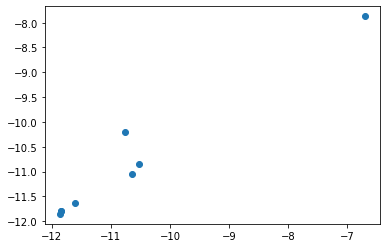

In [47]:
plt.scatter(v_e, s_e)


## Structures for validation of the SNAPs

In [51]:
with mp.MPRester("v0JVgKLlpTXKEhiKeDIC") as m:
    Si_results = m.query(criteria={"pretty_formula":'Si'},
                            properties=["exp.tags", "icsd_ids", "spacegroup",
                                        "task_id", "density", "final_structure",
                                        "e_above_hull", "energy", "energy_per_atom"])

In [107]:
liqamocryst[1].info['dft_energy']

-10795.798922

In [99]:
Si_v_e = [i['energy_per_atom'] for i in Si_results]
Si_s_e = [[] for i in range(len(pots))]
Si_s_s = [[] for i in range(len(pots))]
for i in Si_results:
    at = pase.AseAtomsAdaptor().get_atoms(i['final_structure'])
    for i, val in enumerate(pots):
        at.set_calculator(val)
        Si_s_s[i].append(at.get_stress(voigt=False))
        Si_s_e[i].append(at.get_potential_energy()/len(at))

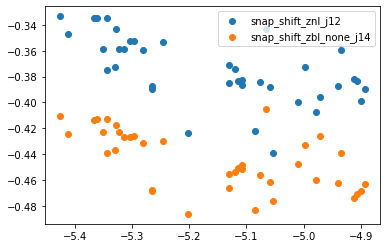

In [102]:
# plt.scatter(Si_v_e, Si_s_e[0])
# plt.scatter(Si_v_e, Si_s_e[1], label=pots[1].name)
# plt.scatter(Si_v_e, Si_s_e[5], label=pots[5].name)
# plt.scatter(Si_v_e, Si_s_e[8], label=pots[8].name)
plt.scatter(Si_v_e, Si_s_e[9], label=pots[9].name)
plt.scatter(Si_v_e, Si_s_e[10], label=pots[10].name)
plt.legend()
# plt.scatter(Si_v_e, Si_s_e[3])
# plt.scatter(Si_v_e, Si_s_e[4])
# plt.scatter(Si_v_e, Si_s_e[2])

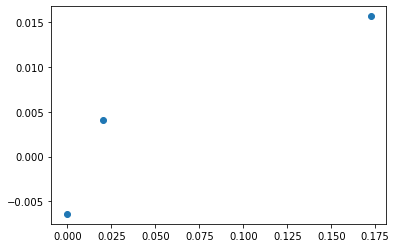

In [81]:
plt.scatter(np.trace(Si_s_s[1]), np.trace(Si_s_s[3]))

In [103]:
print(np.corrcoef(Si_v_e, Si_s_e[1])[0,1], pots[1].name)
print(np.corrcoef(Si_v_e, Si_s_e[5])[0,1], pots[5].name)
print(np.corrcoef(Si_v_e, Si_s_e[6])[0,1], pots[6].name)
print(np.corrcoef(Si_v_e, Si_s_e[7])[0,1], pots[7].name)
print(np.corrcoef(Si_v_e, Si_s_e[8])[0,1], pots[8].name)
print(np.corrcoef(Si_v_e, Si_s_e[9])[0,1], pots[9].name)
print(np.corrcoef(Si_v_e, Si_s_e[10])[0,1], pots[10].name)

0.9391258331483617 snap_shift
0.9357718867381037 snap_shift_zbl_mod
0.9080665022557157 snap_shift_znl_none
0.8647920005203157 snap_shift_zbl_none_j6
-0.47367810873791105 snap_shift_j10
-0.6060875349403093 snap_shift_znl_j12
-0.5934428216798416 snap_shift_zbl_none_j14


In [139]:
selection = [pots[1], GAP_example]
Si_s_myDB_val_E = [[] for i in range(len(selection))]
Si_s_myDB_val_S = [[] for i in range(len(selection))]
Si_s_myDB_val_F = [[] for i in range(len(selection))]
for i, val in enumerate(selection):
    for j in liqamocryst:
        at = j
        at.set_calculator(val)
        Si_s_myDB_val_S.append(at.get_stress(voigt=False))
        Si_s_myDB_val_E.append(at.get_potential_energy()/len(at))
        Si_s_myDB_val_F.append(at.get_forces())


AttributeError: 'tuple' object has no attribute 'get_stress'

In [116]:
zero_e = liqamocryst[0].info['dft_energy']
myDB_DFT_E = [i.info['dft_energy']/len(i) - zero_e for i in liqamocryst]

In [130]:
myDB_DFT_F = flatten([i.arrays['dft_force'].flatten() for i in liqamocryst])
F = flatten([i.flatten() for i in Si_s_myDB_val_F])

(-4.5, -3.0)

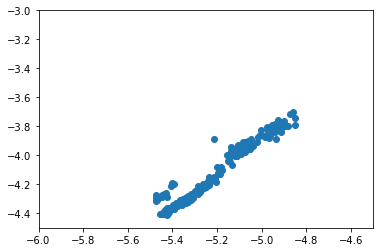

In [122]:
plt.scatter(myDB_DFT_E, Si_s_myDB_val_E)
plt.xlim((-6,-4.5))
plt.ylim((-4.5,-3))

(-8.0, 8.0)

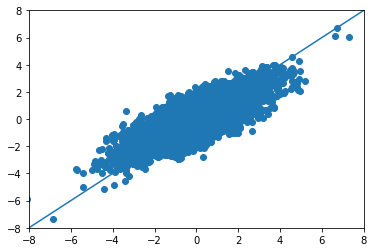

In [134]:
plt.scatter(myDB_DFT_F, F)
plt.plot(x := np.linspace(-8,8,100), x)
plt.xlim((-8,8))
plt.ylim((-8,8))